<h1><center>CS6140 Project - COVID-19 Tweet Scanner</center></h1>

<h1><center>BERT</center></h1>

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

### Importing Libraries

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-processing via sklearn.
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Transformers modules.
from transformers import BertTokenizerFast
from transformers import TFBertModel

# Keras
import tensorflow as tf


# M.L Statistics.
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

# Setting seed value for reproducibility.
seed = 42

### Reading the data
Here we read from the data set into pandas data frame

In [3]:
df = pd.read_csv('Corona_NLP_train.csv', usecols=['OriginalTweet', 'Sentiment'], encoding='ISO-8859-1')
df_test = pd.read_csv('Corona_NLP_train.csv', usecols=['OriginalTweet', 'Sentiment'], encoding='ISO-8859-1') 

# Observing the structure of data.
print(f" DF SHAPE      : {df.shape}")
print(f" DF TEST SHAPE : {df_test.shape}")

 DF SHAPE      : (41157, 2)
 DF TEST SHAPE : (41157, 2)


### Pre-Processing Steps

The idea is to make data ready for the training.
We perform steps below:
1. Label Re-Mapping  (Converting text labels to numberical class values).
2. Data Sanitisation (Removing elements from our data which hurts the performance/working of the model).
3. Data Balancing    (Balancing the number of training examples w.r.t train labels).
4. Data Splitting    (Dividing our data into trainable and validation set).
5. One-Hot Encoding  (Making numeric classes into list, every index represent a class, value at that index is the truth val. of class).
6. Data Re-formatting (Converting our textual data in to encoded data so as to be input into BERT layers).

In [4]:
# Using pre-trained tokeniser for BERT.
# AutoTokenizer.from_pretrained('bert-base-cased') can be used if library issues occur.
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')  

In [5]:
# # Extracting number of token in a sentence for all data.
# token_lengths = []
# max_tokens_to_keep = 256  # Upon prior testing we got a max of 248 token in a tweet, so we keep 256 for now.

# for a_sentence in df['Tweet'].values:
#     a_sentence = str(a_sentence)
    
#     # Returns the encoded token list. Ex: "Hello World" ==> [456, 5678]
#     encodeded_tokens_list = tokenizer.encode(a_sentence, max_length=max_tokens_to_keep, truncation=True)
    
#     token_lengths.append(len(encodeded_tokens_list))

In [6]:
# # To ensure previous step work fine, below code can justify.
# max_len = np.max(token_lens)
# print(max_len)

In [7]:
# Having a another look of our data distribution from target value point of view.
print(df['Sentiment'].value_counts())

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64


### Label Re-Mapping

In [8]:
# We wish to continue with only 3 Target values.
# So, we combine them to reduce it to 3.
# Now, 
# Neg + Extr. Neg ==> "-1" / "Negative"
# Pos + Extr. Pos ==> "+1" / "Positive"
# Neutral         ==> "+0" / "Neutral"

# Commented code allows us to play with target values and may be useful for learning purposes.

df['Sentiment'] = df['Sentiment'].map(
    # {'Extremely Negative': -2, 'Negative': -1, 'Neutral': 0, 'Positive': 1, 'Extremely Positive': 2}
    {'Extremely Negative': -1, 'Negative': -1, 'Neutral': 0, 'Positive': 1, 'Extremely Positive': 1}
)

df_test['Sentiment'] = df_test['Sentiment'].map(
    # {'Extremely Negative': -2, 'Negative': -1, 'Neutral': 0, 'Positive': 1, 'Extremely Positive': 2}
    {'Extremely Negative': -1, 'Negative': -1, 'Neutral': 0, 'Positive': 1, 'Extremely Positive': 1}
)

In [9]:
print(df['Sentiment'].value_counts())
print(df_test['Sentiment'].value_counts())

 1    18046
-1    15398
 0     7713
Name: Sentiment, dtype: int64
 1    18046
-1    15398
 0     7713
Name: Sentiment, dtype: int64


### Data Preprocessing

In [11]:
import re

# Generally, the hyperlinks does not contribute to the sentiment of a tweet, hence removing them is a good idea.
df['Tweet'] = df['OriginalTweet'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
df_test['Tweet'] = df_test['OriginalTweet'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

# Here we remove special characters, numbers, punctuations.
df['Tweet'] = df['Tweet'].str.replace('[^a-zA-Z#]+',' ')
df_test['Tweet'] = df_test['Tweet'].str.replace('[^a-zA-Z#]+',' ')

### Oversampling - Data Balancing

The classes excluding the class with the highest number of samples, are over-sampled to match the sample size of the most frequent class.

In [12]:
# train data is imbalanced, so we oversample our data.

from imblearn.over_sampling import RandomOverSampler

random_over_sampler = RandomOverSampler()

train_x, train_y = random_over_sampler.fit_resample(np.array(df['Tweet']).reshape(-1, 1), np.array(df['Sentiment']).reshape(-1, 1))

In [13]:
temp_df = pd.DataFrame ({'Sentiment': train_y })
temp_df['Sentiment'].value_counts()

-1    18046
 1    18046
 0    18046
Name: Sentiment, dtype: int64

In [15]:
# We create new Data Frame for clarity, this DF is contains our Over-Sampled Data.

train_sentences_list = [x[0] for x in train_x]
tweet_sentiment_tuple_list = list(zip(train_sentences_list, train_y))

# over sampled train data frame
o_s_train_df = pd.DataFrame(tweet_sentiment_tuple_list, columns = ['Tweet', 'Sentiment'])

In [16]:
# o_s_train_df.head()

In [17]:
# train_os['Sentiment'].value_counts()
# train_os = train_os.dropna()

In [18]:
train_values = o_s_train_df['Tweet'].values
target_values = o_s_train_df['Sentiment'].values

### Data Splitting

In [19]:
# Let us use the data to create splits of the data.
X_train, X_valid, y_train, y_valid = train_test_split(train_values, target_values, test_size=0.1, stratify=target_values, random_state=seed)

In [20]:
# Dropping null values from test data
df_test = df_test.dropna()
# df = df.dropna()

# Preparing test data
X_test = df_test['Tweet'].values  # df_test
y_test = df_test['Sentiment'].values  # df_test

### One-Hot Encoding

This technique is used to match the number of output layer neurons

In [21]:
# fitting and transforming the data
ohe = preprocessing.OneHotEncoder()

y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [22]:
y_train

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [23]:
# We can see that we had 3 classes and every class is now represented by a list (will be treated as a vector by NN model).

In [24]:
# Let us recap amount of data we have individually.
print(f"TRAINING    DATA: {X_train.shape[0]}\nVALIDATION  DATA: {X_valid.shape[0]}\nTESTING     DATA: {X_test.shape[0]}" )

TRAINING    DATA: 48724
VALIDATION  DATA: 5414
TESTING     DATA: 41157


In [25]:
# Maximum length of a sentence [after encoding]
# As we are bound by limited computing resources, we could not go beyond this.
MAX_LEN=180  # This will be treated as number of neurons in later stage.

 ### Transforming textual data using encoding

In [26]:
# Let us now define a function which will convert our textual data in to encoded data so as to be input into BERT layers. 
def tokenize_for_bert(given_text_data, max_len=MAX_LEN) :
    input_id_list, attention_masks_list = [], []
    # c = 0
    for i in range(len(given_text_data)):
        # try:
        encoded_data = tokenizer.encode_plus(given_text_data[i], add_special_tokens=True, max_length=max_len, padding='max_length', return_attention_mask=True)
        # except TypeError:
            # print(f"\n\n{data[i]}\n\n")
            # c+=1
            
        input_id_list.append(encoded_data['input_ids'])
        attention_masks_list.append(encoded_data['attention_mask'])
    # print(len(data), c)
    return np.array(input_id_list), np.array(attention_masks_list)  # converting them in to numpy array so that it is treated as vectors.


In [27]:
# Utilising "tokenize_for_bert" function to get data to be fed into NN.
train_input_ids, train_attention_masks = tokenize_for_bert(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize_for_bert(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize_for_bert(X_test, MAX_LEN)

In [29]:
# train_attention_masks[0]

# NN Modelling

#### Taking the pre trained BERT model.

In [30]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


#### Setting up a function with semi-predefined parameters.

In [31]:
# This function will create an End to End Neural Network model for our cllassification purpose.
def create_model(bert_model, max_len=MAX_LEN):
    
    # # Setting up hyper parameters for our Neural Network.
    
    # Adam combines the best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems.
    optimiser = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-7)  
    
    # Categorical crossentropy loss function is suitable multi-class classification tasks.
    loss_function = tf.keras.losses.CategoricalCrossentropy()
    
    # Because we are using one-hot encoded target (Y) values, and we know that,
    # Categorical Accuracy calculates the percentage of predicted values (Y-Pred) that match with actual values (Y-True) for one-hot labels.
    # Hence it suits our case.
    accuracy_metric = tf.keras.metrics.CategoricalAccuracy()


    # Setting Up Pre-Requisite Layers for BERT.
    input_ids_layer = tf.keras.Input(shape=(max_len,),dtype='int32')  # creating a NN layer for Input Ids.
    attention_masks_layer = tf.keras.Input(shape=(max_len,),dtype='int32')  # creating a NN layer for Input Ids.
    
    # Setting Up BERT Embeddings Layer.
    # Fun Fact : This is the particular layer which will gives us contextualised vectors for our input sentences.
    bert_embeddings_layer = bert_model([input_ids_layer, attention_masks_layer])[1]
    
    # The layer which will gives us the classifications.
    # Activation function ==> "Softmax" || Because, in general for multi-class classification problems it is best suited.
    output_layer = tf.keras.layers.Dense(3, activation="softmax")(bert_embeddings_layer)
    
    # Defining The input and Output Layers
    BERT_NN = tf.keras.models.Model(inputs = [input_ids_layer, attention_masks_layer], outputs = output_layer)
    
    # The Compile function defines the loss function, the optimizer and the metrics for our Neu. Net. .
    BERT_NN.compile(optimiser, loss=loss_function, metrics=accuracy_metric)
    
    
    return BERT_NN

#### Model implementation

In [32]:
# Creating the model.
BERT_NN = create_model(bert_model, MAX_LEN)

# Displaying a summary of our model
BERT_NN.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 180)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 3)            2307        tf_bert_model[0][1]          

### Model Training

In [34]:
## Putting model on training now.
history_object_for_our_model = \
BERT_NN.fit(
    x= [train_input_ids, train_attention_masks], 
    y= y_train,
    validation_data=([val_input_ids, val_attention_masks], y_valid),
    epochs=4,  # 4
    batch_size=16
)

Epoch 1/4
3046/3046 [==============================] - 754s 247ms/step - loss: 0.2342 - categorical_accuracy: 0.9163 - val_loss: 0.2276 - val_categorical_accuracy: 0.9224
Epoch 2/4
3046/3046 [==============================] - 755s 248ms/step - loss: 0.1559 - categorical_accuracy: 0.9458 - val_loss: 0.2192 - val_categorical_accuracy: 0.9285
Epoch 3/4
3046/3046 [==============================] - 756s 248ms/step - loss: 0.1062 - categorical_accuracy: 0.9629 - val_loss: 0.1895 - val_categorical_accuracy: 0.9442
Epoch 4/4
3046/3046 [==============================] - 755s 248ms/step - loss: 0.0701 - categorical_accuracy: 0.9759 - val_loss: 0.2131 - val_categorical_accuracy: 0.9446


In [35]:
# history_object_for_our_model.params

#### Predicting the test data

In [36]:
prediction_result = BERT_NN.predict([test_input_ids, test_attention_masks])

In [37]:
# Creating an n-d array, the shape of the array will be as our "prediction_result".
y_pred = np.zeros_like(prediction_result)

# We need to do this because, the output from the NN will be some values, 
# and we need to check which one of them is max and hence that will be the predicted class.

In [38]:
# Here we set the value 1, to the place in a prediction, which holds the maximum value.
y_pred[np.arange(len(y_pred)), prediction_result.argmax(1)] = 1

# print(prediction_result.argmax(1))
# print(np.arange(len(y_pred)))

## Performance Results

In [39]:
## Defining function for the confusion matrix.
def show_confusion_matrix(y, _y_pred, title):
    fig, ax =plt.subplots(figsize=(8,8))
    
    # labels=['Extreme Negative', 'Negative', 'Neutral', 'Positive', 'Extreme Positive']
    labels=['Negative', 'Neutral', 'Positive']  # In relative order of -1, 0 , +1 .
    
    ax=sns.heatmap(confusion_matrix(y, _y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=18) 
    ax.yaxis.set_ticklabels(labels, fontsize=18)
    ax.set_ylabel('TEST CLASSES', fontsize=20)
    ax.set_xlabel('PREDICTED CLASSES', fontsize=20)
    plt.show()

### Plotting the confusion matrix

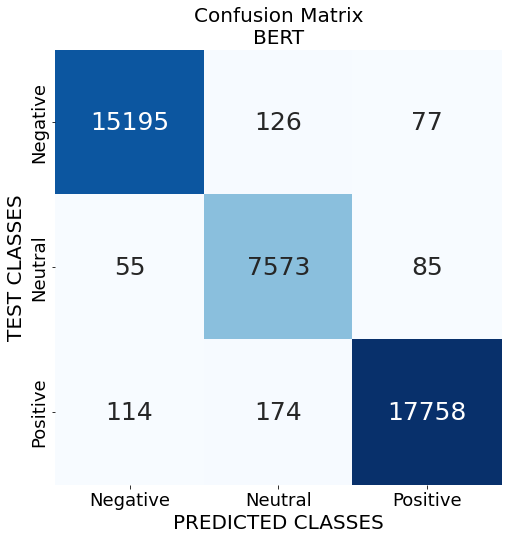

In [40]:
show_confusion_matrix(y=y_test.argmax(1), _y_pred=y_pred.argmax(1), title='Confusion Matrix\nBERT')

### Evaluation Results

In [41]:
print('_______________Classification Report for BERT_______________\n\n')

classif_obj = classification_report(y_test, y_pred, 
                                    target_names=['Negative', 'Neutral', 'Positive']  # ['Extreme Negative', 'Negative', 'Neutral', 'Positive', 'Extreme Positive']
                                   )
print(classif_obj)
     
print(f"\nTest Accuracy -----> {accuracy_score(y_test,y_pred)}")
# print(f"Train Accuracy --> {accuracy_score(y_test,y_pred)}")

_______________Classification Report for BERT_______________


              precision    recall  f1-score   support

    Negative       0.99      0.99      0.99     15398
     Neutral       0.96      0.98      0.97      7713
    Positive       0.99      0.98      0.99     18046

   micro avg       0.98      0.98      0.98     41157
   macro avg       0.98      0.98      0.98     41157
weighted avg       0.98      0.98      0.98     41157
 samples avg       0.98      0.98      0.98     41157


Test Accuracy -----> 0.9846684646597177
